# Number Plate Detection and Extrction of number plate from the Car Image

In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
# from PIL import Image
# import pytesseract
# pytesseract.pytesseract.tesseract_cmd=r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [2]:
class ANPD:
    def __init__(self, weight_file: str, cfg_file: str, classes: str):
        self.net = cv2.dnn.readNet(weight_file, cfg_file)
        self.classes = []
        with open(classes, 'r') as f:
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        self.color = (255, 0, 0)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None
        
        
    def detection(self, img_path: str):
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames()
        layer_outputs = self.net.forward(output_layer_names)
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores) 
                confidence = scores[class_id]
                if confidence > 0.2:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3]* height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = str(round(confidences[i],2))
                cv2.rectangle(img, (x,y), (x+w-5, y+h-5), self.color, 3)
                cv2.putText(img, label +' '+ confidence, (x, y), self.font, 1, (255, 255, 255), 1)
        self.fig_image = img
        self.coordinates = (x, y, w, h)
        return

    def crop_number_plate(self):
        x, y, w, h = self.coordinates
        roi = self.img[y:y + h-5, x:x + w-5]
        self.roi_image = roi
        return

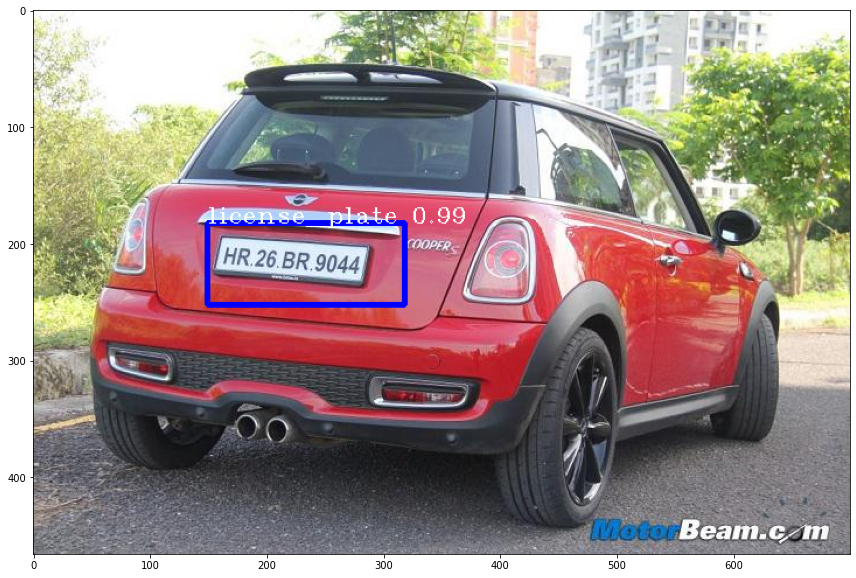

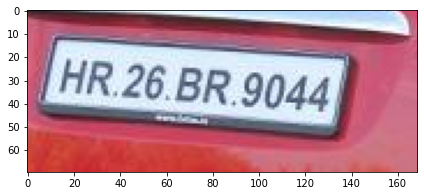

In [3]:
lpd = ANPD(
    weight_file='yolov3-train_final.weights', 
    cfg_file='yolov3-testing.cfg', 
    classes='classes.txt'
)

# Detect license plate
lpd.detection('car_40.jpeg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(24,10))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.savefig('detected.jpeg')
plt.show()

# Crop plate and show cropped plate
lpd.crop_number_plate()
plt.figure(figsize=(7,3))
plt.imshow(cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB))
# plt.savefig("Cropped.jpeg")

# Number Plate Detection and Extrction of number plate from the Video

In [7]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
class ANPD:
    def __init__(self, weight_file: str, cfg_file: str, classes: str):
        self.net = cv2.dnn.readNet(weight_file, cfg_file)
        self.classes = []
        with open(classes, 'r') as f:
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        self.color = (255, 0, 0)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None
        
    def detection(self, img_path: str):
        stream = cv2.VideoCapture(img_path)
        i=0 #frame counter
        frameTime = 1
        currentframe = 0
        while True:
            ret=stream.grab()
            i=i+1
            if i % 3 == 0:
                ret, img=stream.retrieve()
                if ret:
                    height, width,ret= img.shape
                    blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
                    self.net.setInput(blob)
                    output_layer_names = self.net.getUnconnectedOutLayersNames()
                    layer_outputs = self.net.forward(output_layer_names)
                else:
                    break
                boxes = []
                confidences = []
                class_ids = []
                for output in layer_outputs:
                    for detection in output:
                        scores = detection[5:]
                        class_id = np.argmax(scores) 
                        confidence = scores[class_id]
                        if confidence > 0.2:
                            center_x = int(detection[0] * width)
                            center_y = int(detection[1] * height)
                            w = int(detection[2] * width)
                            h = int(detection[3]* height)
                            x = int(center_x - w / 2)
                            y = int(center_y - h / 2)
                            boxes.append([x, y, w, h])
                            confidences.append((float(confidence)))
                            class_ids.append(class_id)
                indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

                if len(indexes) > 0:
                    for i in indexes.flatten():
                        x, y, w, h = boxes[i]
                        label = str(self.classes[class_ids[i]])
                        confidence = str(round(confidences[i],2))
                        cv2.rectangle(img, (x,y), (x+w-5, y+h-5), self.color, 3)
                        cv2.putText(img, label +' '+ confidence, (x, y), self.font, 1, (255, 255, 255), 1)
                        if int(confidence[i]) == 0:
                            name = 'capture' + str(currentframe) + '.jpg'
                            cv2.imwrite(name, img)
                            currentframe += 1
                        else:
                            pass

                cv2.imshow('frame',img)
                if cv2.waitKey(frameTime) & 0xFF == 27:
                    break
        stream.release()
        cv2.destroyAllWindows()
        

In [9]:
lpd = ANPD(
    weight_file='yolov3-train_final.weights', 
    cfg_file='yolov3-testing.cfg', 
    classes='classes.txt'
)

# Detect license plate
lpd.detection('Video_2.mp4')



In [6]:
# value=Image.open('Cropped.jpeg')
# text = pytesseract.image_to_string(value, config='--psm 11')
# print("Detected license plate Number is:",text)